In [ ]:
try:
    import torch  
    print('Module torch was installed')
except ImportError:    
    print("Installinng torch 1.8.1")
    !pip install -q torch==1.8.1
try:
    import torchvision  
    print('Module torchvision was installed')
except ImportError:    
    print("Installinng torchvision 0.4.0")
    !pip install -q torchvision==0.4.0
    
try:
    import qiskit  
    print('Module qiskit was installed')
except ImportError:    
    print("Installinng qiskit 0.29.0")
    !pip install -q qiskit==0.29.0
import sys
!pip install pylatexenc
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VYR5kM8oCGaMXPIq0K1UY7u53a77vmHA' -O codes.tar.gz
!tar zxvf /content/codes.tar.gz

sys.path.append('/content/libs/')



Module torch was installed
Module torchvision was installed
Module qiskit was installed
--2021-08-16 05:19:12--  https://docs.google.com/uc?export=download&id=1VYR5kM8oCGaMXPIq0K1UY7u53a77vmHA
Resolving docs.google.com (docs.google.com)... 142.250.141.113, 142.250.141.138, 142.250.141.139, ...
Connecting to docs.google.com (docs.google.com)|142.250.141.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-as-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bipe6ou5d0hk2qedsqd566du9k402l6p/1629091125000/01567206451901200540/*/1VYR5kM8oCGaMXPIq0K1UY7u53a77vmHA?e=download [following]
--2021-08-16 05:19:13--  https://doc-00-as-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bipe6ou5d0hk2qedsqd566du9k402l6p/1629091125000/01567206451901200540/*/1VYR5kM8oCGaMXPIq0K1UY7u53a77vmHA?e=download
Resolving doc-00-as-docs.googleusercontent.com (doc-00-as-docs.googleusercontent.com)... 142.251.2.

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


import sys
import functools
from qiskit import  QuantumCircuit, ClassicalRegister
from qiskit import Aer, execute
from qiskit.circuit import Qubit
import math

from circuit.lib_qiskit_commons import *
from circuit.lib_circuit_linner_square import *
from training.lib_dataloader import *

import qiskit

print = functools.partial(print, flush=True)

from qiskit import Aer, execute,IBMQ,transpile
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import *
from qiskit import circuit


####TODO:change simulator,add errors.####
def my_ibmq(circuit,shots,Simulation = True,backend_name='ibmq_essex'):     
    if not Simulation:
        provider = IBMQ.get_provider('ibm-q-academic')
        backend = provider.get_backend(backend_name)
    else:
        backend = Aer.get_backend('qasm_simulator')
    # circuit.save_statevector()
    p_gate = 0.01
    x_error_1 = pauli_error([('X',p_gate), ('I', 1 - p_gate)])
    z_error_1 = pauli_error([('Z',p_gate), ('I', 1 - p_gate)])

    error_1 = x_error_1.compose(z_error_1)
    error_2 = error_1.tensor(error_1)
    error_3 = error_2.tensor(error_1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ["x"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_1, ["z"]) # single qubit gate error is applied to x gates

    noise_model.add_all_qubit_quantum_error(error_2, ["cx"]) # two qubit gate error is applied to cx gates
    noise_model.add_all_qubit_quantum_error(error_2, ["cz"]) # two qubit gate error is applied to cx gates

    noise_model.add_all_qubit_quantum_error(error_3, ["ccx"])

    basis_gates = noise_model.basis_gates
    job_ibm_q = execute(circuit, backend, shots=shots, basis_gates=basis_gates, noise_model=noise_model)
    if not Simulation:
        job_monitor(job_ibm_q)
    result_ibm_q = job_ibm_q.result()

    counts = result_ibm_q.get_counts()
    
    return counts

In [20]:
def equa(circuit,in_qubits,out_qubit,aux = []):
  for i in range(3):
            circuit.h(in_qubits[i])
            circuit.x(in_qubits[i])
  circuit.barrier()
  #first ccx
  circuit.cx(in_qubits[0], aux[0])
  circuit.cx(in_qubits[0], aux[0])
  circuit.cx(in_qubits[1], aux[0])
  circuit.cx(in_qubits[1], aux[0])
  circuit.cx(in_qubits[0], in_qubits[1])
  circuit.cx(in_qubits[0], in_qubits[1])
  #second ccx
  circuit.cx(in_qubits[2], aux[1])
  circuit.cx(in_qubits[2], aux[1])
  circuit.cx(aux[0], aux[1])
  circuit.cx(aux[0], aux[1])
  circuit.cx(in_qubits[2], aux[0])
  circuit.cx(in_qubits[2], aux[0])
  circuit.cz(aux[1], out_qubit[0])
  #third ccx
  circuit.cx(in_qubits[2], aux[1])
  circuit.cx(in_qubits[2], aux[1])
  circuit.cx(aux[0], aux[1])
  circuit.cx(aux[0], aux[1])
  circuit.cx(in_qubits[2], aux[0])
  circuit.cx(in_qubits[2], aux[0])
  #fourth ccx
  circuit.cx(in_qubits[0], aux[0])
  circuit.cx(in_qubits[0], aux[0])
  circuit.cx(in_qubits[1], aux[0])
  circuit.cx(in_qubits[1], aux[0])
  circuit.cx(in_qubits[0], in_qubits[1])
  circuit.cx(in_qubits[0], in_qubits[1])        


In [21]:
def func(circuit,in_qubits,out_qubit,aux = []):
  for i in range(3):
            circuit.h(in_qubits[i])
            circuit.x(in_qubits[i])
  circuit.barrier()
  #first ccx
  circuit.cx(in_qubits[0], aux[0])
  circuit.cx(in_qubits[0], aux[0])
  circuit.cx(in_qubits[1], aux[0])
  circuit.cx(in_qubits[1], aux[0])
  circuit.swap(aux[0], in_qubits[1])
  circuit.cx(in_qubits[0], in_qubits[1])
  circuit.cx(in_qubits[0], in_qubits[1])
  #second ccx
  circuit.cx(in_qubits[2], aux[1])
  circuit.cx(in_qubits[2], aux[1])
  circuit.cx(aux[0], aux[1])
  circuit.cx(aux[0], aux[1])
  circuit.swap(aux[1], in_qubits[2])
  circuit.cx(in_qubits[2], aux[0])
  circuit.cx(in_qubits[2], aux[0])
  circuit.cz(aux[1], out_qubit[0])
  #third ccx
  circuit.cx(in_qubits[2], aux[1])
  circuit.cx(in_qubits[2], aux[1])
  circuit.swap(in_qubits[2], aux[1])
  circuit.cx(aux[0], aux[1])
  circuit.cx(aux[0], aux[1])
  circuit.cx(aux[1], in_qubits[2])
  circuit.cx(aux[0], aux[1])
  circuit.cx(aux[1], in_qubits[2])
  circuit.cx(aux[0], aux[1])
  circuit.cx(in_qubits[2], aux[0])
  circuit.cx(in_qubits[2], aux[0])
  #fourth ccx
  circuit.swap(in_qubits[1], aux[0])
  circuit.cx(in_qubits[0], aux[0])
  circuit.cx(in_qubits[0], aux[0])
  circuit.cx(in_qubits[1], aux[0])
  circuit.cx(in_qubits[1], aux[0])
  circuit.cx(aux[0], in_qubits[1])
  circuit.cx(in_qubits[0], in_qubits[1])        
  circuit.cx(aux[0], in_qubits[1])
  circuit.cx(in_qubits[0], in_qubits[1])
  circuit.cx(in_qubits[0], in_qubits[1])
  circuit.cx(in_qubits[0], in_qubits[1])        


## define parameters

In [22]:
#define parameter
input_data_num =50
init_weight = torch.tensor([[-1,-1,1,1,1,1,1,1]],dtype=torch.double)
threshold = 0.2
qubit_num = 3

def sign(input):
    output = input.new(input.size())
    output[input >= threshold] = 1
    output[input < threshold] = -1
    return output

## generate datasets

In [23]:


#get correct result with no error

input_data = torch.rand(input_data_num,int(math.pow(2,qubit_num)),dtype=torch.double)
input_data_quantum_matrix = []
for i in range(input_data_num):
    quantum_matrix =to_quantum_matrix(input_data[i])
    # n1_q_gates,n1_idx =ULayerCircuit.extract_from_weight(init_weight[0])
    input_data_quantum_matrix.append(quantum_matrix[:, 0].view(-1))

input_data_quantum_matrix = torch.stack(input_data_quantum_matrix)
# print(input_data_quantum_matrix.t()[0:8].t())
# print(input_data_quantum_matrix)
correct_result =torch.mm(init_weight,input_data_quantum_matrix.t())
correct_result = correct_result*correct_result/math.pow(2,qubit_num)
# print(correct_result)
correct_result_binary = sign(correct_result.t())
print(correct_result_binary.t())
torch.save(input_data, "./liang_random_data.pt")
torch.save(correct_result_binary.view(-1), "./liang_random_target.pt")
torch.save(init_weight, "./liang_weight.pt")


tensor([[ 1., -1.,  1.,  1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1.,  1.,
         -1., -1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,
         -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1., -1., -1.,
          1.,  1.,  1., -1., -1.,  1., -1., -1.]], dtype=torch.float64)


## define forward,including mapping 

correct result  : tensor(1., dtype=torch.float64)
Result : 0.0126953125


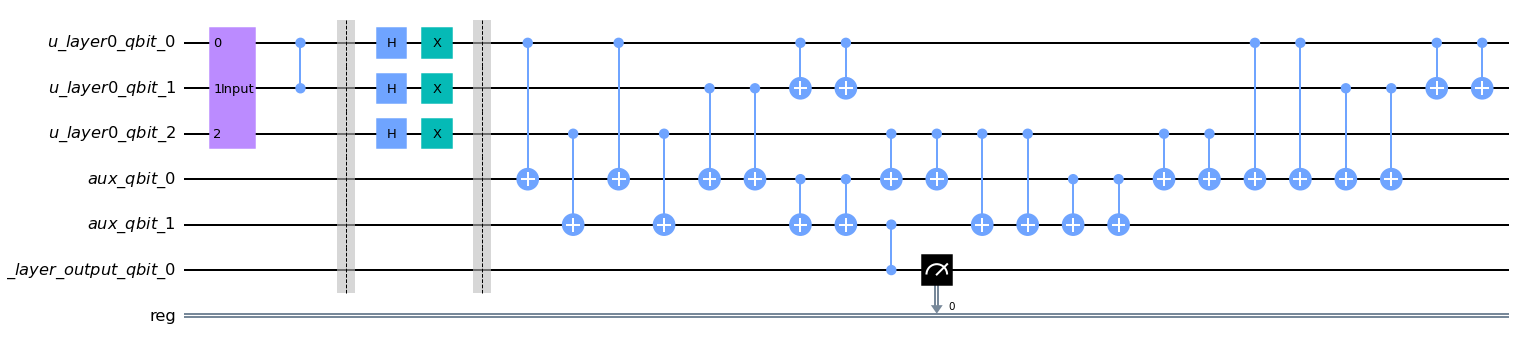

In [24]:

#example of u-layer
i = 0
#transform input_data into u-Mat
quantum_matrix =to_quantum_matrix(input_data[i])

def forward(circuit,quantum_matrix,weight, is_mapping = False):
    #generate u-layer
    #define your input and output number
    u_layer = ULayerCircuit(qubit_num,1) 
    #init circuit
    #add input qubit to your circuit
    inps = u_layer.add_input_qubits(circuit)
    
    aux = u_layer.add_aux(circuit)
    
    #add output qubit to your circuit
    u_layer_out_qubits = u_layer.add_out_qubits(circuit)
    
    #add ulayer to your circuit
    #add ulayer to your circuit
    u_layer.add_weight(circuit,weight,inps,quantum_matrix,aux)

    ####TODO: add mapping code here ####

    ############################
    
    if is_mapping:
        func(circuit,inps[0],u_layer_out_qubits,aux)
    else:
        equa(circuit,inps[0],u_layer_out_qubits,aux)
    
    #measure
    c_reg = ClassicalRegister(1,"reg")
    circuit.add_register(c_reg)
    circuit.measure(u_layer_out_qubits[0],c_reg[0])
    
    #get the result
    qc_shots=8192
    opt_class_prob = []
    opt_counts = my_ibmq(circuit,qc_shots,True)
    (opt_mycount,bits) = analyze(opt_counts)
    for b in range(bits):
        opt_class_prob.append(float(opt_mycount[b])/qc_shots)
    return opt_class_prob[0]

circuit = QuantumCircuit()
prob = forward(circuit,quantum_matrix,init_weight, False)
print("correct result  :",correct_result_binary[i][0])
print("Result :",prob)
circuit.draw('mpl',fold=50)


######################################################



In [ ]:
!pip install pylatexenc

## train and test

In [25]:
from torchvision import datasets
circuit_result = []


input_data = torch.load("./liang_random_data.pt")
target = torch.load("./liang_random_target.pt")
target = target.int()
correct_weight = torch.load("./liang_weight.pt")

#weight = torch.tensor([[1,1,1,1,1,1,1,1]],dtype=torch.double)
weight = correct_weight

input_data_num =  target.shape[0]
train_num = int(input_data_num *0.8)
#train
for i in range(train_num):
    quantum_matrix =to_quantum_matrix(input_data[i])
    circuit = QuantumCircuit()   
    prob = forward(circuit,quantum_matrix,weight)
    if prob >= threshold :
        res = 1
    else:
        res = -1
    ##TODO:update weight#

    #####################

print("weight :",weight)

#test
for i in range(train_num,input_data_num):
    quantum_matrix =to_quantum_matrix(input_data[i])

    circuit = QuantumCircuit()   
    prob = forward(circuit,quantum_matrix,weight)

    if prob >= threshold :
        circuit_result.append(1)
    else:
        circuit_result.append(-1)

circuit_result_tensor = torch.tensor(circuit_result,dtype=torch.double)
circuit_result_tensor = circuit_result_tensor.int()
error_num = (circuit_result_tensor != target[train_num:input_data_num]).sum()

print("error_num :",error_num)
print("error_rate:",float(error_num)/(input_data_num - train_num))

weight : tensor([[-1., -1.,  1.,  1.,  1.,  1.,  1.,  1.]], dtype=torch.float64)
error_num : tensor(4)
error_rate: 0.4


In [ ]:
###example of define qubit
circuit = QuantumCircuit()
qubit_list = []
input1 = QuantumRegister(4,'q')

input2 = QuantumRegister(2,'a')
circuit.add_register(input1)
circuit.add_register(input2)
for i in range(4):
    qubit_list.append(Qubit(input1, i))
for i in range(2):
    qubit_list.append(Qubit(input1, i))
circuit.x(qubit_list[3])
circuit.draw('mpl')

CircuitError: 'index must be under the size of the register: 4 was provided'